1. Setup and Imports

In [1]:
# Cell 1: Setup and Imports
import sys
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from typing import List, Dict

# Add project root to path
project_root = str(Path.cwd().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project modules
from src.data.data_processing import DataProcessor
from src.models.model_training import ModelTrainer

# Load base configuration
with open('configs/config.yml', 'r') as f:
    base_config = yaml.safe_load(f)

2. Load Processed Data

In [2]:
# Load the already processed data
processed_data_path = base_config['data']['processed_data_path']
raw_data_file_name = base_config['data']['raw_data_file_name']
df = pd.read_csv(f"{processed_data_path}processed_{raw_data_file_name}")

# Get target column
target_column_name = base_config['data']['raw_data_target_column']['name']
if base_config['data']['raw_data_target_column']['type'] == 'categorical':
    target_column_name = f'{target_column_name}_categorical_encoded'

# Prepare data
X = df.drop(columns=[target_column_name])
y = df[target_column_name]

# Store feature names for later use
training_features = X.columns.tolist()
print("Number of training features:", len(training_features))
print("First few features:", training_features[:5])

FUNCTIONS

In [3]:
# Create comparison visualizations
def plot_experiment_comparisons(results):
    # Extract metrics for comparison
    experiment_names = [r['experiment_name'] for r in results]
    accuracies = [r['metrics'].get('accuracy', 0) for r in results]
    f1_scores = [r['metrics'].get('f1', 0) for r in results]
    
    # Plot comparisons
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(experiment_names, accuracies)
    plt.title('Accuracy Comparison')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.bar(experiment_names, f1_scores)
    plt.title('F1 Score Comparison')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [4]:
# Add cross-validation to ensure consistent performance
def validate_model_stability(trainer, X, y, n_splits=5):
    """
    Validate model stability using cross-validation.
    
    Args:
        trainer: Your ModelTrainer instance
        X: Feature matrix
        y: Target vector
        n_splits: Number of CV splits
    """
    # Get the underlying sklearn model
    model = trainer.model.model
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=n_splits)
    
    print("\nCross-validation Results - validate_model_stability(...) :")
    print(f"Individual scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return cv_scores

In [5]:
def analyze_important_words(trainer, feature_columns: List[str], top_n: int = 10):
    """
    Analyze and display most important features for prediction.
    
    Args:
        trainer: Your ModelTrainer instance
        feature_columns: List of feature column names from DataFrame
        top_n: Number of top features to display
    """
    # Get feature importance from the model
    model = trainer.model.model
    importances = model.feature_importances_
    
    # Create dictionary of feature importances
    importance_dict = dict(zip(feature_columns, importances))
    
    # Sort by importance value
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Take top N features
    top_features = sorted_features[:top_n]
    
    print("\nTop Important Features:")
    print("-" * 40)
    print("Feature Name".ljust(30) + "Importance")
    print("-" * 40)
    
    for feature_name, importance in top_features:
        # Clean feature name
        clean_name = feature_name.replace('tweet_feature_', '')
        print(f"{clean_name.ljust(30)} {importance:.4f}")
    
    return dict(top_features)

In [6]:

# Optional: Visualize feature importance
import matplotlib.pyplot as plt

def plot_feature_importance(importance_dict, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    
    # Get feature names and importance values
    features = [k.replace('tweet_feature_', '') for k in importance_dict.keys()]
    values = list(importance_dict.values())
    
    # Create horizontal bar plot
    y_pos = np.arange(len(features))
    plt.barh(y_pos, values)
    plt.yticks(y_pos, features)
    plt.xlabel('Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()

3. Experiment: Different Model Configurations


 Start evaluation algorithm:  Deep Trees Model


 MODEL TRAINER: SUPERVISED_CLASSIFICATION algorithm will be used

 MODEL FACTORY: Random Forest Classifier will be used for training with the following parameters: 
{'n_estimators': 500, 'max_depth': 25, 'random_state': 42, 'min_samples_split': 2}

Cross-validation Results - validate_model_stability(...) :
Individual scores: [0.66909365 0.65863252 0.66122688 0.65746088 0.65921834]
Mean CV score: 0.661 (+/- 0.008)

Top Important Features:
----------------------------------------
Feature Name                  Importance
----------------------------------------
amazon                         0.2757
get                            0.0336
make                           0.0276
johnson                        0.0236
google                         0.0209
playing                        0.0191
still                          0.0190
fucking                        0.0177
ca                             0.0174
look                           0.0173
know 

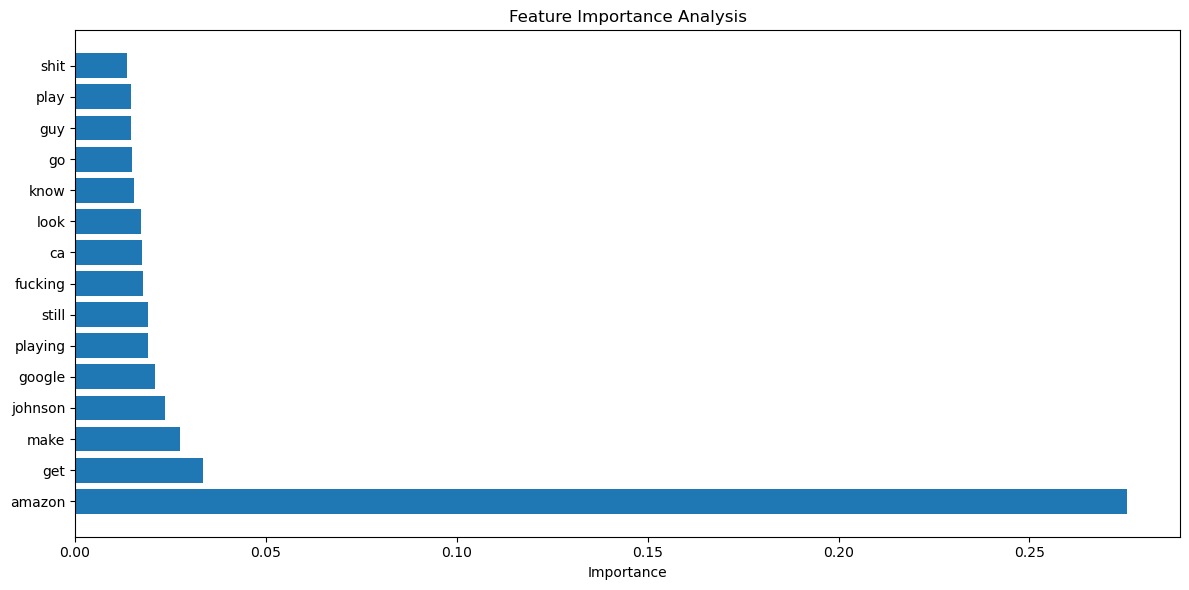


Experimented: Deep Trees Model
With parameters: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 2}
Metrics results: {'accuracy': 0.6615616369570675, 'precision': 0.663108465781634, 'recall': 0.6615616369570675, 'f1': 0.660579973940584}

 Start evaluation algorithm:  Text Optimized Model


 MODEL TRAINER: SUPERVISED_CLASSIFICATION algorithm will be used

 MODEL FACTORY: Random Forest Classifier will be used for training with the following parameters: 
{'n_estimators': 200, 'max_depth': 15, 'random_state': 42, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced'}

Cross-validation Results - validate_model_stability(...) :
Individual scores: [0.51401791 0.49836806 0.50824337 0.50899657 0.50774123]
Mean CV score: 0.507 (+/- 0.010)

Top Important Features:
----------------------------------------
Feature Name                  Importance
----------------------------------------
amazon                         0.2210
get                

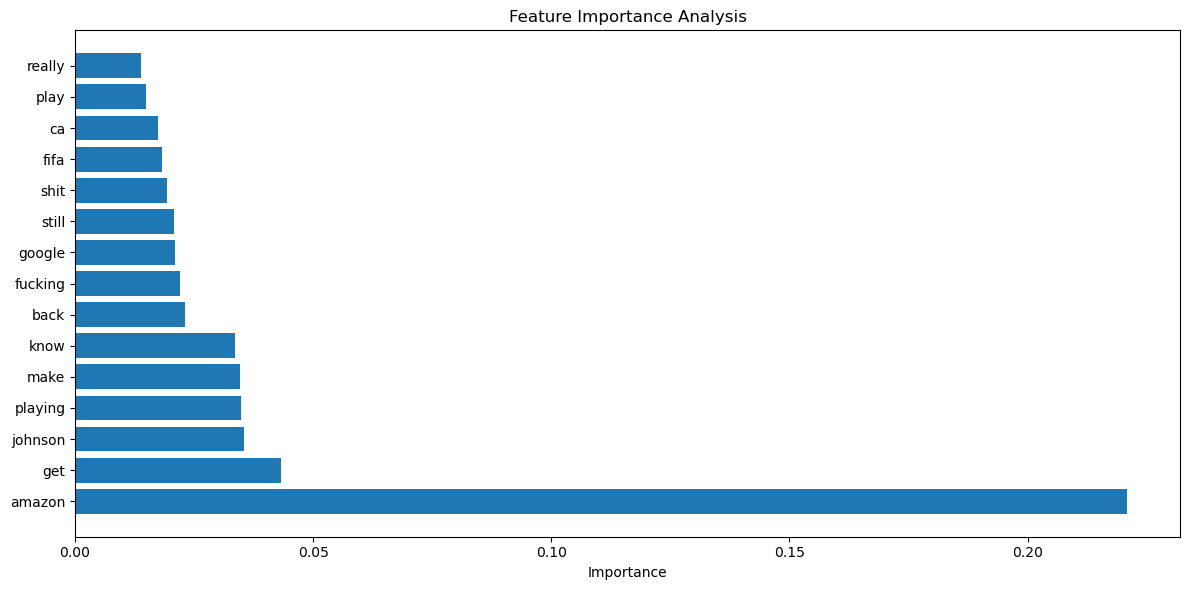


Experimented: Text Optimized Model
With parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced'}
Metrics results: {'accuracy': 0.5095823918319524, 'precision': 0.5540811386862066, 'recall': 0.5095823918319524, 'f1': 0.5127160666176634}

 Start evaluation algorithm:  Deep Ensemble


 MODEL TRAINER: SUPERVISED_CLASSIFICATION algorithm will be used

 MODEL FACTORY: Random Forest Classifier will be used for training with the following parameters: 
{'n_estimators': 900, 'max_depth': 20, 'random_state': 42, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'bootstrap': True}

Cross-validation Results - validate_model_stability(...) :
Individual scores: [0.58306134 0.56406394 0.58080174 0.5765336  0.57393924]
Mean CV score: 0.576 (+/- 0.013)

Top Important Features:
----------------------------------------
Feature Name                  Import

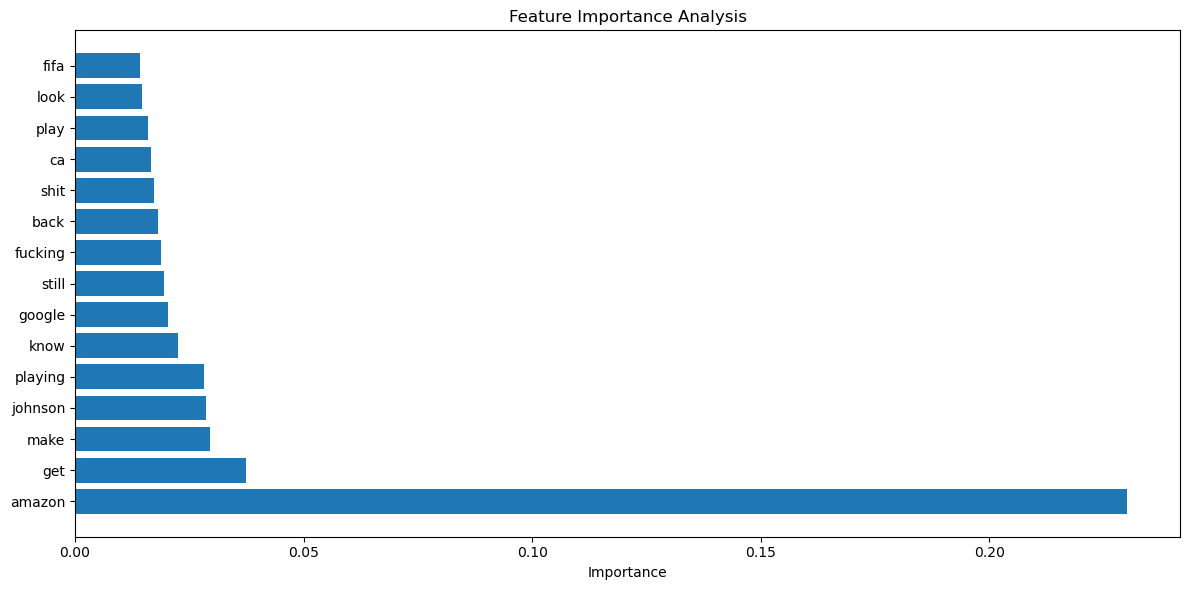


Experimented: Deep Ensemble
With parameters: {'n_estimators': 900, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced_subsample'}
Metrics results: {'accuracy': 0.5772868022428655, 'precision': 0.6156231397394348, 'recall': 0.5772868022428655, 'f1': 0.5822048150505721}


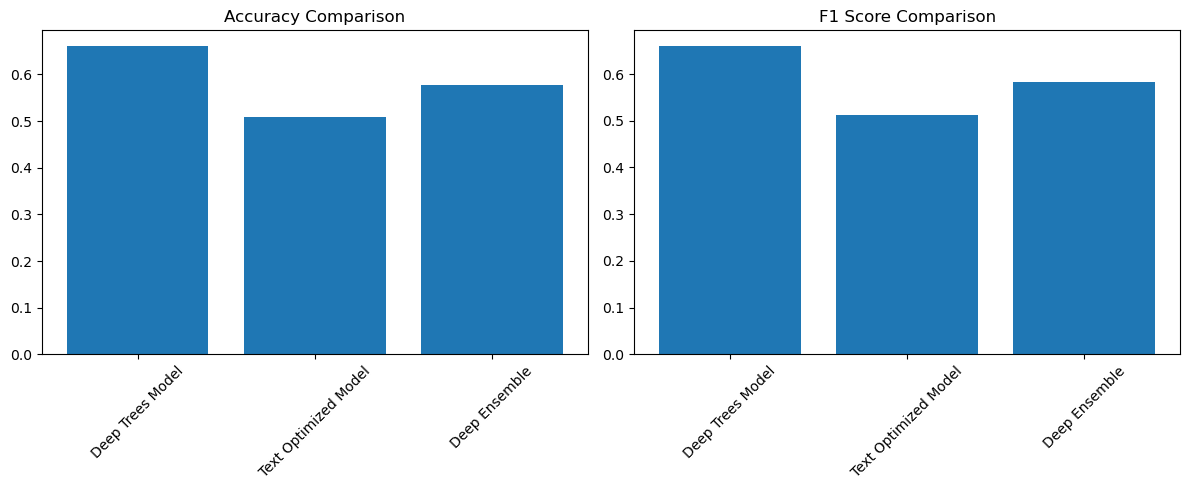

In [7]:
# Cell 3: Model Training Functions
def run_experiment(config_variations, X, y):
    """Run experiments with different model configurations."""
    results = []
    
    for variant in config_variations:
        print('\n Start evaluation algorithm: ', variant['name'] + '\n') 
        
        # Create new config for this experiment
        experiment_config = base_config.copy()
        experiment_config['training']['model']['params'].update(variant['params'])
        
        # Train model
        trainer = ModelTrainer(experiment_config)
        
        # Store training features in trainer
        trainer.training_features = training_features
        
        metrics = trainer.train_model(X, y)
        
        # Store results
        results.append({
            'experiment_name': variant['name'],
            'params': variant['params'],
            'metrics': metrics,
            'trainer': trainer,
            'training_features': training_features  # Store features with results
        })

        # Analyze model stability and features
        cv_scores = validate_model_stability(trainer, X, y, n_splits=5)
        feature_columns = [col for col in X.columns if col.startswith('tweet_feature_')]
        importance_dict = analyze_important_words(trainer, feature_columns, top_n=15)
        plot_feature_importance(importance_dict)

        print(f"\nExperiment: {variant['name']}")
        print("Parameters:", variant['params'])
        print("Metrics:", metrics)
    
    return results

# Define experiment configurations
config_variations = [
    {
        'name': 'Deep Trees Model',
        'params': {
            'n_estimators': 500,
            'max_depth': 25,
            'min_samples_split': 2
        }
    },
    {
        'name': 'Text Optimized Model',
        'params': {
            'n_estimators': 200,
            'max_depth': 15,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'class_weight': 'balanced'
        }
    },
    {
        'name': 'Deep Ensemble',
        'params': {
            'n_estimators': 900,
            'max_depth': 20,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'log2',
            'bootstrap': True,
            'class_weight': 'balanced_subsample'
        }
    }
]

# Run experiments
experiment_results = run_experiment(config_variations, X, y)

#Analyze Results
plot_experiment_comparisons(experiment_results)

In [8]:

# Find best result based on accuracy
best_result = max(experiment_results, key=lambda x: x['metrics']['accuracy'])
    
# Get the trainer of the best model
best_trainer = best_result['trainer']


TEST PREDICTION WITH DATA TEST

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_on_test_data(trainer, data_test_preprocessed_df):
    """
    Evaluate the model on test data.
    
    Args:
        trainer: Trained ModelTrainer instance
        data_test_preprocessed_df: Preprocessed test DataFrame
    
    Returns:
        dict: Test metrics
    """

    # Prepare test features and target
    target_column = trainer.config['data']['raw_data_target_column']['name']
    if trainer.config['data']['raw_data_target_column']['type'] == 'categorical':
        target_column = f'{target_column}_categorical_encoded'
    
    # Split features and target
    X_test = data_test_preprocessed_df.drop(columns=[target_column])
    y_test = data_test_preprocessed_df[target_column]
    
    # Make predictions
    y_pred = trainer.predict(X_test)
    
    # Calculate metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    # Print results
    print("\nTest Set Evaluation:")
    print("-" * 40)
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on Test Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Compare train vs test performance
    print("\nTrain vs Test Performance:")
    print("-" * 40)
    
    # Get the most recent training metrics from history
    train_metrics = trainer.training_history[-1]['metrics'] if trainer.training_history else {}
    
    for metric in test_metrics.keys():
        train_value = train_metrics.get(metric, 0)
        test_value = test_metrics[metric]
        diff = abs(train_value - test_value)
        print(f"{metric}:")
        print(f"  Train: {train_value:.4f}")
        print(f"  Test:  {test_value:.4f}")
        print(f"  Diff:  {diff:.4f}")
    
    return test_metrics

In [10]:
# Load processed test data
import os
file_name, file_extension = os.path.splitext(raw_data_file_name)
test_file_name = f"{file_name}_test{file_extension}"
test_df = pd.read_csv(f"{processed_data_path}processed_{test_file_name}")


Test Set Evaluation:
----------------------------------------
accuracy: 0.6640
precision: 0.6654
recall: 0.6640
f1: 0.6627


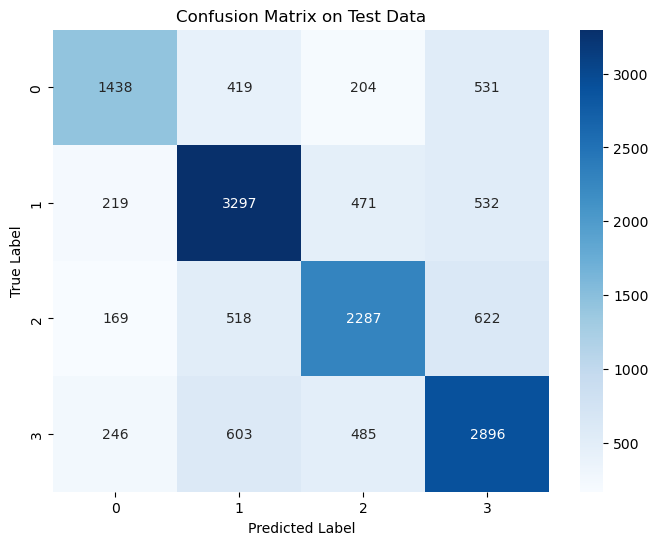


Train vs Test Performance:
----------------------------------------
accuracy:
  Train: 0.6616
  Test:  0.6640
  Diff:  0.0024
precision:
  Train: 0.6631
  Test:  0.6654
  Diff:  0.0023
recall:
  Train: 0.6616
  Test:  0.6640
  Diff:  0.0024
f1:
  Train: 0.6606
  Test:  0.6627
  Diff:  0.0022


In [11]:
# After training and selecting best model, let see the prediction with data test
test_metrics = evaluate_on_test_data(best_trainer, test_df)

SAVE THE BEST ALGORITH BASE ON OUR PREVIOUS EXPERIME?TATION

In [12]:
# Cell 4: Save Best Model
def save_best_model(experiment_results):
    """Save the best performing model with feature information."""
    # Find best result based on accuracy
    best_result = max(experiment_results, key=lambda x: x['metrics']['accuracy'])
    
    # Get the trainer of the best model
    best_trainer = best_result['trainer']

    # Get paths for saving
    relative_path_name = base_config['model']['name']
    relative_path_version = base_config['model']['version']
    
    # Create model path
    model_saved_relative_path_directory = f"models/{relative_path_name}/{relative_path_version}"
    model_saved_name = best_result['experiment_name']
    
    # Add timestamp to model name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_saved_name = f"{model_saved_name}_{timestamp}"
    
    # Save the model with training features
    best_trainer.training_features = best_result['training_features']
    best_trainer.save_model(model_saved_relative_path_directory, model_saved_name)
    
    print(f"\nBest Model Details:")
    print("-" * 40)
    print(f"Model Name: {best_result['experiment_name']}")
    print(f"Parameters: {best_result['params']}")
    print(f"Metrics: {best_result['metrics']}")
    print(f"Number of features: {len(best_result['training_features'])}")
    print(f"\nModel saved to: {model_saved_name}")
    
    return f"{model_saved_relative_path_directory}/{model_saved_name}", best_trainer, best_result['metrics']

# Save the best model
model_path, best_trainer, metrics = save_best_model(experiment_results)

In [13]:
save_best_model(experiment_results)

Model saved to models/example_model/0.1.0/Deep Trees Model_20250111_223336

Best Model Details:
----------------------------------------
Model Name: Deep Trees Model
Parameters: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 2}
Metrics: {'accuracy': 0.6615616369570675, 'precision': 0.663108465781634, 'recall': 0.6615616369570675, 'f1': 0.660579973940584}

Model saved to: Deep Trees Model


('models/example_model/0.1.0/Deep Trees Model',
 {'accuracy': 0.6615616369570675,
  'precision': 0.663108465781634,
  'recall': 0.6615616369570675,
  'f1': 0.660579973940584})